In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, mean_squared_error
from sklearn.linear_model import Lasso, Ridge, ElasticNet

## Load Data


In [13]:
# load and prep data
with open('./data/training set.pkl', 'rb') as fp:
    
    train_data = pickle.load(fp)
 
train_data.reset_index(drop = True, inplace = True)
train_data.dropna(inplace = True)

y =  train_data['lnpercapitaconsumption']
X = train_data.drop(columns = ['lnpercapitaconsumption'])
# scale 


# split data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.50, random_state=42)
poly = PolynomialFeatures(degree = 2, interaction_only=True)
X_train_2 = poly.fit_transform(X_train)
X_test_2 = poly.fit_transform(X_test)

In [3]:
def utility(y_pred, level, rho, benefits = 272):
    
    #274*1e6/12

    # pick out poor people
    is_poor = y_pred < level
    num_poor = np.sum(is_poor)
    # decide how much each poor gets
    gets_benefits = is_poor * benefits
    benefit_per_people = gets_benefits / num_poor
    # give the poor money
    add_benefits = y_pred + benefit_per_people 
    #utility calculations
    numerator = np.power(add_benefits, 1 - rho)
    
    results = np.sum(numerator)/(1 - rho)
    
    return results

# lets make a function to calculate inclusion/exclusion error and correct inclusion/exlusion

def inex(predicted, actual, level, incl: bool, err: bool):
     
    #the funciton takes in 5 values and returns one value
    #predicted - should be an array of predicted y values according to the model that you used
    #actual - actual values of a training or testing data set, as a dataframe with an index
    #level - scalar which is used to determining the threshold 
    
    
    predicted_threshold = np.zeros(len(y))
    
    if incl is True:
        predicted_threshold = (predicted < np.percentile(predicted,level))
    else:
        predicted_threshold = (predicted > np.percentile(predicted,level))
    
    actual_threshold = np.zeros(len(y))
    
    if err is True and incl is True:
        actual_threshold = (actual > np.percentile(predicted,28))
    elif err is True and incl is False:
        actual_threshold = (actual < np.percentile(predicted,28))
    elif err is False and incl is False:
        actual_threshold = (actual > np.percentile(predicted,28))
    else:
        actual_threshold = (actual < np.percentile(predicted,28))
    
        
    data = pd.DataFrame(index = range(0,len(predicted)), columns = ["actual","predicted"])
    data["actual"] = actual_threshold.values
    data["predicted"] = predicted_threshold
    
    z = np.logical_and(data["actual"], data["predicted"])
    value = len(z[z == True]) / len(predicted)
    
    return value

In [4]:
# train all the models
with open('./models/lassobest.pkl', 'rb') as fp:
    lasso = pickle.load(fp)
    
with open('./models/ridgebest.pkl', 'rb') as fp:
    ridge = pickle.load(fp)
    
with open('./models/elbest.pkl', 'rb') as fp:
    elastic = pickle.load(fp)

C:\Users\Villem\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Villem\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Ridge from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Villem\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Villem\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator ElasticNet from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at 

In [9]:
elastic.best_params_

{'alpha': 0.0018957356524063754, 'l1_ratio': 0.1}

In [14]:
ridge.best_params_

{'alpha': 0.31622776601683794}

In [15]:
lasso_pred = lasso.predict(X_test_2)
lasso_pred_exp = np.exp(lasso_pred)
ridge_pred = ridge.predict(X_test_2)
ridge_pred_exp = np.exp(ridge_pred)
el_pred = elastic.predict(X_test_2)

In [17]:
el_pred.shape

(11337,)

In [20]:
mean_squared_error(y_test, lasso_pred)

0.1778190412859709

C:\Users\Villem\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


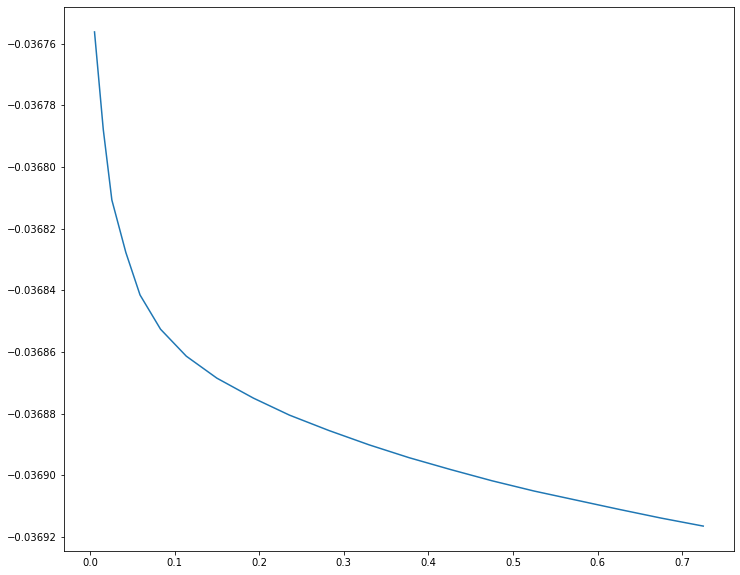

In [10]:
# make the utility graph
cutoff = np.arange(0,105,5)
inclusion = np.zeros(len(cutoff))
ut = inclusion.copy()

for i in range(0,len(cutoff)):
    inclusion[i] = inex(lasso_pred, y_test, cutoff[i], incl = True, err = True) 
    
inclusion

for j in range(len(ut)):
    
    ut[j] = utility(lasso_pred_exp, np.percentile(lasso_pred_exp,j), rho = 3)
    
    
plt.figure(1,figsize= (12,10))
plt.plot(inclusion,ut)

In [78]:
1000/0.28

3571.428571428571

In [52]:
(utility(lasso_pred_exp, np.percentile(lasso_pred_exp,j), rho = 3)>0).sum()

907

In [58]:
utility(lasso_pred_exp, np.percentile(lasso_pred_exp,j), rho = 3)

array([    0.        ,     0.        ,     0.        , ...,
       25174.56817347,     0.        , 25174.56817347])

In [79]:
lasso_pred_exp.shape

(4535,)